# Univariate + Multivariate Regression of Review Scores

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Import modules 
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)

/var/folders/wf/wz1_qkfj6p9g2bq93bwdtvlw0000gn/T/ipykernel_19773/2305605852.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  orders.corr(),


<AxesSubplot: >

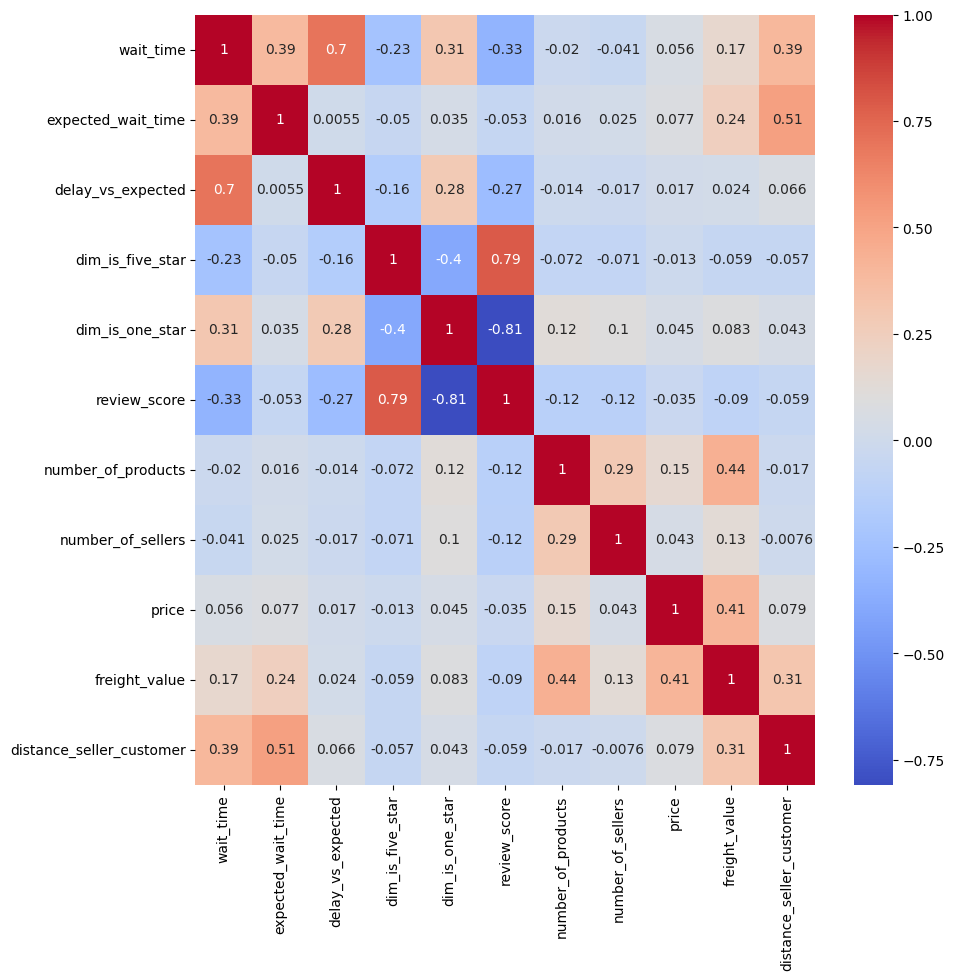

In [7]:
plt.figure(figsize = (10, 10))

sns.heatmap(
    orders.corr(), 
    cmap = 'coolwarm', 
    annot = True, 
    annot_kws = {"size": 10}
)

Using `statsmodels.formula.api` to quickly make
 - `model1`: an ols regression of `review_score` over `wait_time`
 - `model2`: an ols regression of `review_score` over `delay_vs_expected`

Below is a `summary` table for each result:
- Important performance metrics to keep in mind here are `R-squared`, as well as `individual regression coefficients`, `t-values`, `p-values`, and `95% confidence intervals`
- We can use these values to compare it to our heatplot above

### Model 1

In [10]:
import statsmodels.formula.api as smf

model1 = smf.ols('review_score ~ wait_time', data=orders).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                 1.204e+04
Date:                Sat, 04 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:38:23   Log-Likelihood:            -1.5441e+05
No. Observations:               95872   AIC:                         3.088e+05
Df Residuals:                   95870   BIC:                         3.089e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7236      0.006    727.904      0.0

### Model 2

In [11]:
import statsmodels.formula.api as smf

model2 = smf.ols('review_score ~ delay_vs_expected', data=orders).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     7681.
Date:                Sat, 04 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:38:35   Log-Likelihood:            -1.5639e+05
No. Observations:               95872   AIC:                         3.128e+05
Df Residuals:                   95870   BIC:                         3.128e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.2121      0.00

# 2 - Multivariate regression

Understanding 2 features that will help us understand Review Score VS Delay vs Expected **holding wait time constant**

For that reason our 3rd model will keep both wait_time and delay vs expected as the features, and **review score** as the target

#### Model 3

In [12]:
model3 = smf.ols('review_score ~ wait_time + delay_vs_expected', data=orders).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     6191.
Date:                Sat, 04 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:41:48   Log-Likelihood:            -1.5426e+05
No. Observations:               95872   AIC:                         3.085e+05
Df Residuals:                   95869   BIC:                         3.086e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.6502      0.00

- Holding `wait_time` constant, each additional day of `delay` reduces the review_score on average by 0.0205 [0.023 - 0.018] points
- Holding `delay` constant, each additional day of `wait_time` reduces the review_score on average by 0.0383 [0.039 - 0.037] points

Contrary to what was found with the simple bivariate correlation analysis, `delay` is actually less impactful than `wait_time` in driving lower `review_score`! This interesting finding demonstrates the importance of multi-variate regression to remove the potential impact of confounding factors


We will add more features to our regression to improve the explainability of the linear regression

- ⚠️ We will not add features that are directly derived from the `review_score` to prevent Data Leaks
- ⚠️ We will not add two features perfectly collinear with each other
- ⚖️  We will transform each feature $X_i$ into its respective z-score $Z_i = \frac{X_i - \mu_i}{\sigma_i}$ in order to compare the partial regression coefficients $\beta_i$ together. Otherwise, the $\beta_i$ won't be in the same dimension, meaning we'll be comparing apples (e.g. "review_stars per day") with oranges (e.g. "review_stars per BRL")!

Model 4 will have more features from the orders dataset

### Model 4

In [14]:
features = [
    "wait_time",
    "delay_vs_expected",
    "number_of_products",
    "number_of_sellers",
    "price",
    "freight_value",
    "distance_seller_customer",
]

In [16]:
# Standardize features
orders_standardized = orders.copy()
for f in features:
    mu = orders[f].mean()
    sigma = orders[f].std()
    orders_standardized[f] = orders[f].map(lambda x: (x - mu) / sigma)
orders_standardized

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,-0.431192,15.544063,-0.161781,delivered,0,0,4,-0.264595,-0.112544,-0.513802,-0.652038,-0.979475
1,53cdb2fc8bc7dce0b6741e2150273451,0.134174,19.137766,-0.161781,delivered,0,0,4,-0.264595,-0.112544,-0.086640,0.000467,0.429743
2,47770eb9100c2d0c44946d9cf07ec65d,-0.329907,26.639711,-0.161781,delivered,1,0,5,-0.264595,-0.112544,0.111748,-0.164053,-0.145495
3,949d5b44dbf5de918fe9c16f97b45f8a,0.073540,26.188819,-0.161781,delivered,1,0,5,-0.264595,-0.112544,-0.441525,0.206815,2.054621
4,ad21c59c0840e6cb83a9ceb5573f8159,-1.019535,12.112049,-0.161781,delivered,1,0,5,-0.264595,-0.112544,-0.562388,-0.652038,-0.959115
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95875,9c5dedf39a927c1b2549525ed64a053c,-0.454309,18.587442,-0.161781,delivered,1,0,5,-0.264595,-0.112544,-0.311513,-0.449408,-0.893033
95876,63943bddc261676b46f01ca7ac2f7bd8,1.023841,23.459051,-0.161781,delivered,0,0,4,-0.264595,-0.112544,0.183977,-0.123156,-0.212797
95877,83c1379a015df1e13d02aae0204711ab,1.305780,30.384225,-0.161781,delivered,1,0,5,-0.264595,-0.112544,0.333684,1.964490,0.617630
95878,11c177c8e97725db2631073c19f07b62,0.483664,37.105243,-0.161781,delivered,0,0,2,1.601605,-0.112544,1.075186,2.715522,-0.387558


In [17]:
# Create and Train model 4
formula = "review_score ~ " + ' + '.join(features)
model4 = smf.ols(formula = formula, data = orders_standardized).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     2322.
Date:                Sat, 04 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:45:20   Log-Likelihood:            -1.5258e+05
No. Observations:               95872   AIC:                         3.052e+05
Df Residuals:                   95864   BIC:                         3.052e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

<AxesSubplot: >

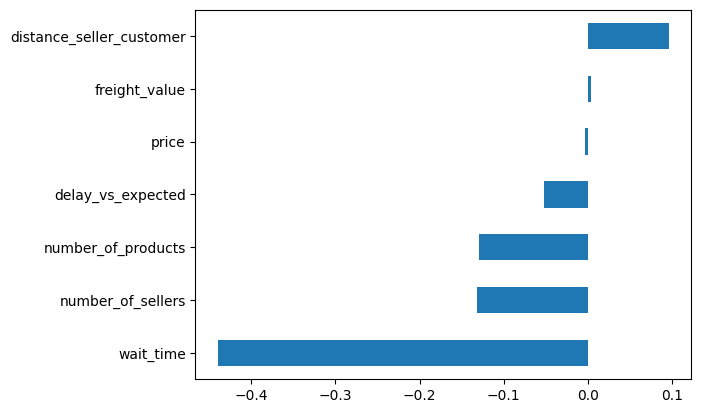

In [18]:
model4.params[1:].sort_values().plot(kind='barh')

### Lets check the model performance 

What will we look for
- Mean of the residuals is equal to 0 
- RMSE
- Residual Histogram


In [19]:
predicted_review_score = model4.predict(orders_standardized[features])
residuals = predicted_review_score - orders_standardized.review_score

In [20]:
# RMSE
rmse = (residuals**2).mean()**0.5
rmse

1.1883154116821097

Text(0.5, 1.0, 'residuals density plot')

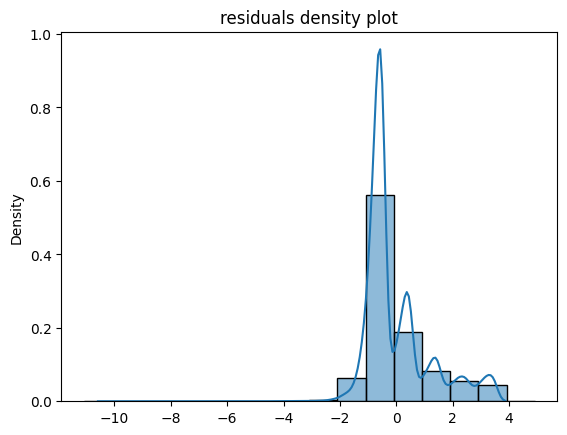

In [21]:
# Residual Histogram
sns.histplot(residuals, kde=True, stat='density', discrete=True)
plt.title('residuals density plot')

Text(0.5, 1.0, 'distribution of predicted and actual values')

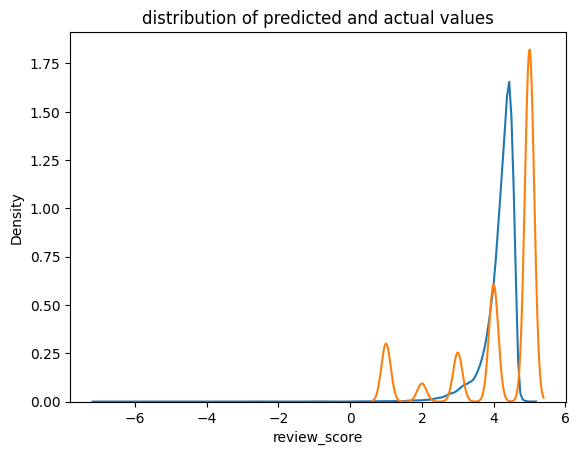

In [22]:
# Distrubution of Review Score vs Predicted Review Score

sns.kdeplot(predicted_review_score, label='predicted review score')
sns.kdeplot(orders.review_score, label = 'actual review score')
plt.title('distribution of predicted and actual values')

(0.0, 5.93454751983985)

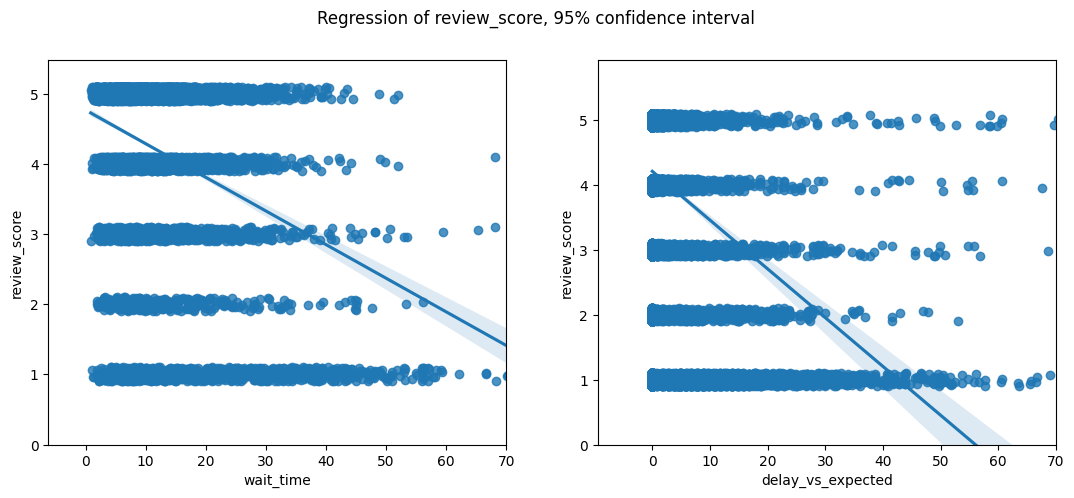

In [23]:
# Regression line with sub-sample of the population AND one with entire population

sample = orders.sample(10000, random_state=42)
plt.figure(figsize=(13,5))
plt.suptitle('Regression of review_score, 95% confidence interval')
plt.subplot(1,2,1)
sns.regplot(x = sample.wait_time, y= sample.review_score, y_jitter=.1, ci=95)
plt.xlim(right=70)
plt.ylim(bottom=0)

plt.subplot(1,2,2)
sns.regplot(x = orders.delay_vs_expected, y= orders.review_score, y_jitter=.1, ci=95)
plt.xlim(right=70)
plt.ylim(bottom=0)

### Results

☝️ It is quite evident that review score will decrease as the wait time increases, with 95% confidence. 

☝️ The greater the delay vs expected wait time, the lower the review score as well. 

☝️ Our model does not seem to be too great for 2 reasons
1. We don't have enough features to explain most of the review scores
2. We are trying to fit the function linearly when it is a discrete classification problem